In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=120,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

In [5]:
batch_size = 64
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

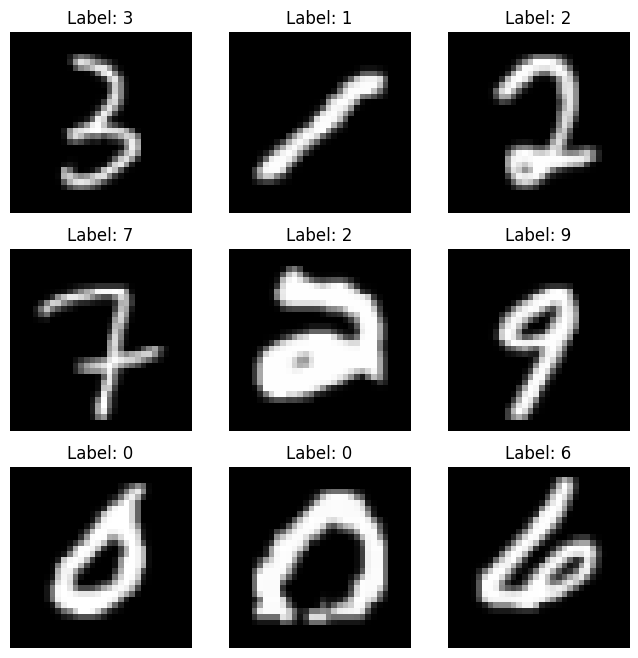

In [6]:
def plot_samples(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(9):
        image = images[i].numpy().squeeze()
        label = labels[i].item()
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")


plt.show()

plot_samples(train_loader)

In [7]:
model = LeNet().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
train_loader.dataset[0][0].shape

torch.Size([1, 32, 32])

In [9]:
NUM_EPOCHS = 32

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(loss.item())
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(loss.item())
    print(
        f"Epoch [{epoch + 1}/{NUM_EPOCHS}], "
        f"Train Accuracy: {train_accuracy:.2f}%, Train Loss: {average_train_loss:.4f}, "
        f"Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {average_val_loss:.4f}"
    )

Epoch [1/32], Train Accuracy: 88.90%, Train Loss: 0.3553, Validation Accuracy: 96.06%, Validation Loss: 0.1281
Epoch [2/32], Train Accuracy: 96.72%, Train Loss: 0.1070, Validation Accuracy: 97.21%, Validation Loss: 0.0876
Epoch [3/32], Train Accuracy: 97.58%, Train Loss: 0.0768, Validation Accuracy: 97.83%, Validation Loss: 0.0695
Epoch [4/32], Train Accuracy: 98.08%, Train Loss: 0.0615, Validation Accuracy: 97.62%, Validation Loss: 0.0755
Epoch [5/32], Train Accuracy: 98.31%, Train Loss: 0.0509, Validation Accuracy: 98.54%, Validation Loss: 0.0494
Epoch [6/32], Train Accuracy: 98.65%, Train Loss: 0.0420, Validation Accuracy: 98.45%, Validation Loss: 0.0508
Epoch [7/32], Train Accuracy: 98.81%, Train Loss: 0.0368, Validation Accuracy: 98.40%, Validation Loss: 0.0529
Epoch [8/32], Train Accuracy: 99.00%, Train Loss: 0.0323, Validation Accuracy: 98.57%, Validation Loss: 0.0478
Epoch [9/32], Train Accuracy: 99.10%, Train Loss: 0.0279, Validation Accuracy: 98.67%, Validation Loss: 0.0461
E

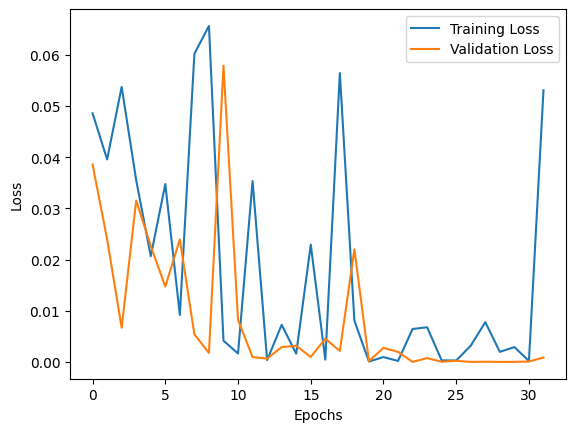

In [10]:
plt.plot(range(NUM_EPOCHS), train_losses, label="Training Loss")
plt.plot(range(NUM_EPOCHS), val_losses, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [12]:
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)

model.eval()

all_predictions = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average="weighted")
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("Classification Report:")
print(classification_report(all_labels, all_predictions))

conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9868
F1 Score: 0.9868
Precision: 0.9869
Recall: 0.9868
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.97      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.97      1.00      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.98      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Confusion Matrix:
[[ 974    0    0    0    0    0    4    1    1    0]
 [   0 1128    0    1    0    2    2    1    1    0]
 [   1    0 1022    0    1 

In [38]:
def plot_images_grid(images, title, rows=4, cols=8):
    images = images.numpy()
    num_images = images.shape[0]

    plt.figure(figsize=(15, 8))
    plt.title(title)

    for i in range(min(num_images, rows * cols)):
        plt.subplot(rows, cols, i + 1)

        if images.shape[3] == 3:
            plt.imshow(images[i].transpose((1, 2, 0)))
        else:
            plt.imshow(images[i, 0])

        plt.axis("off")

    plt.show()

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LeNet(
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
)

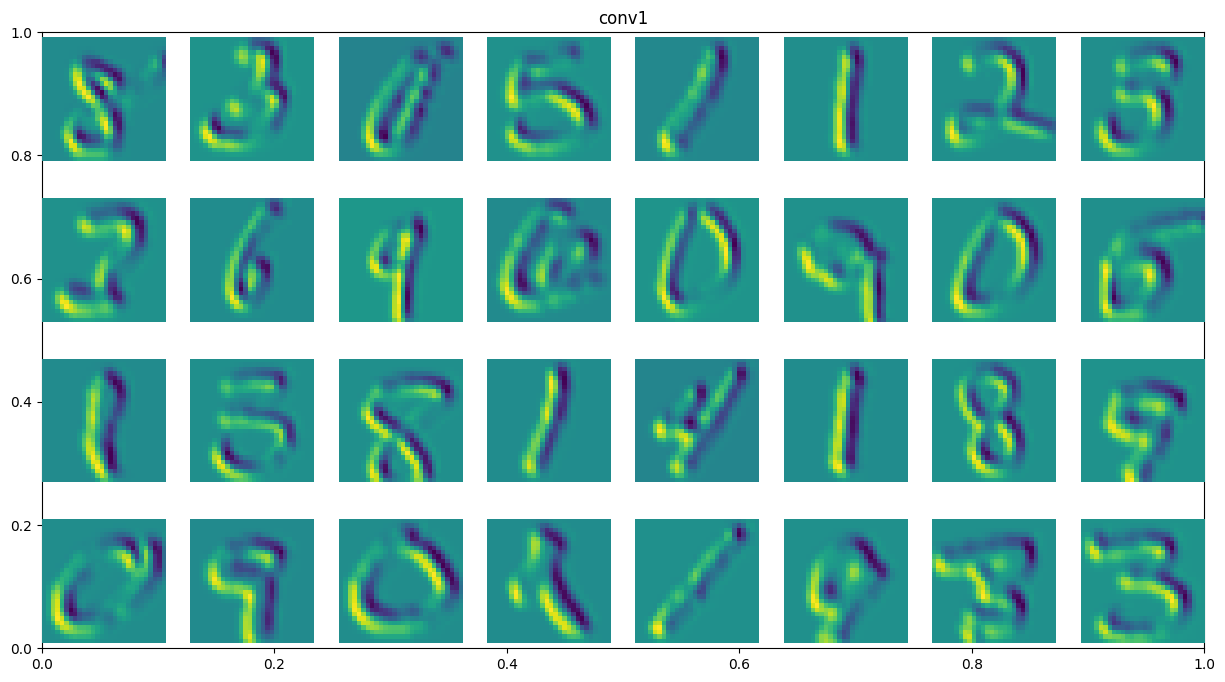

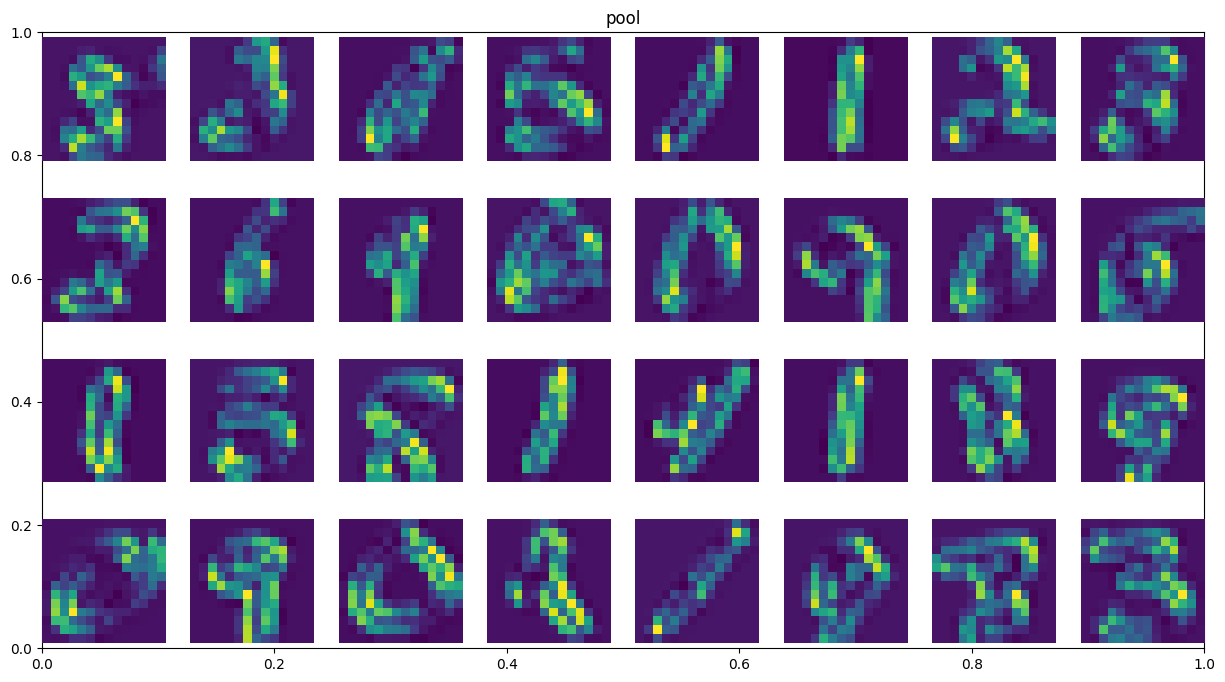

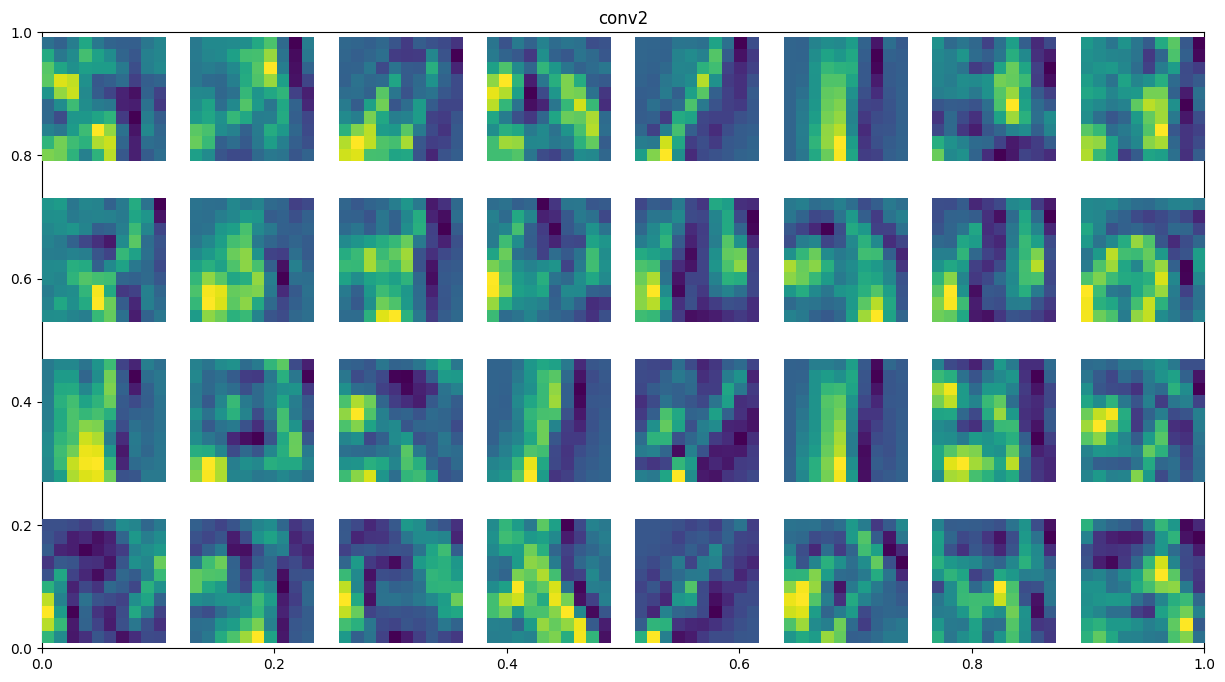

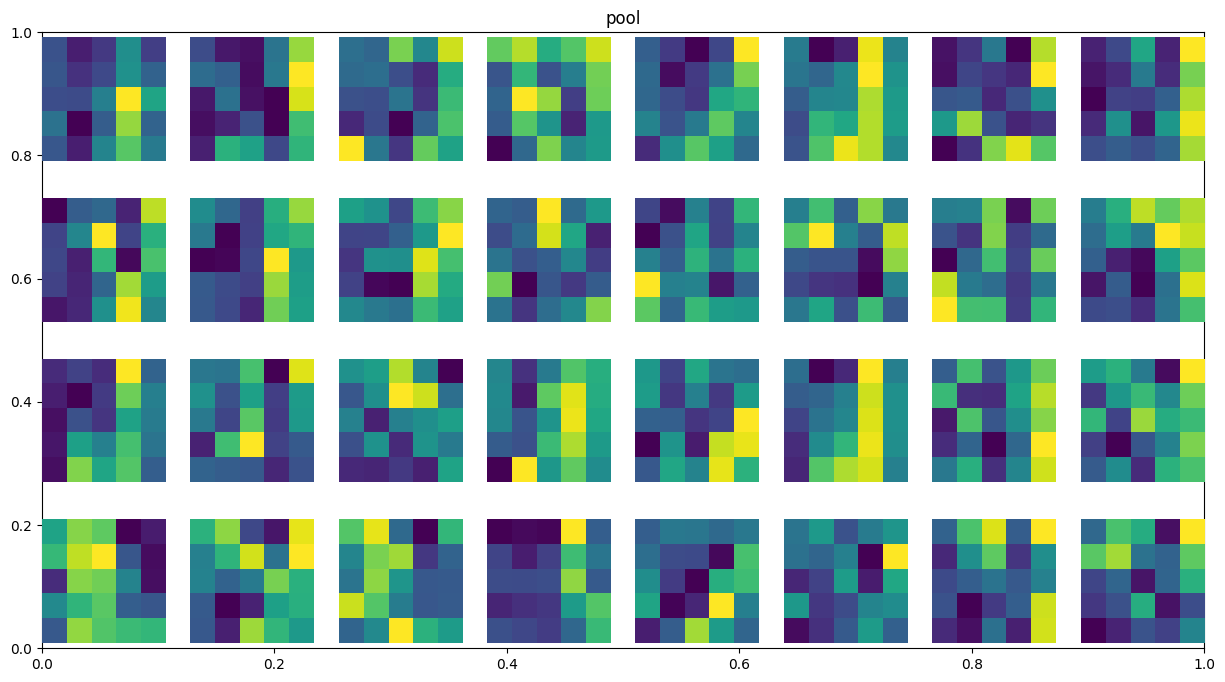

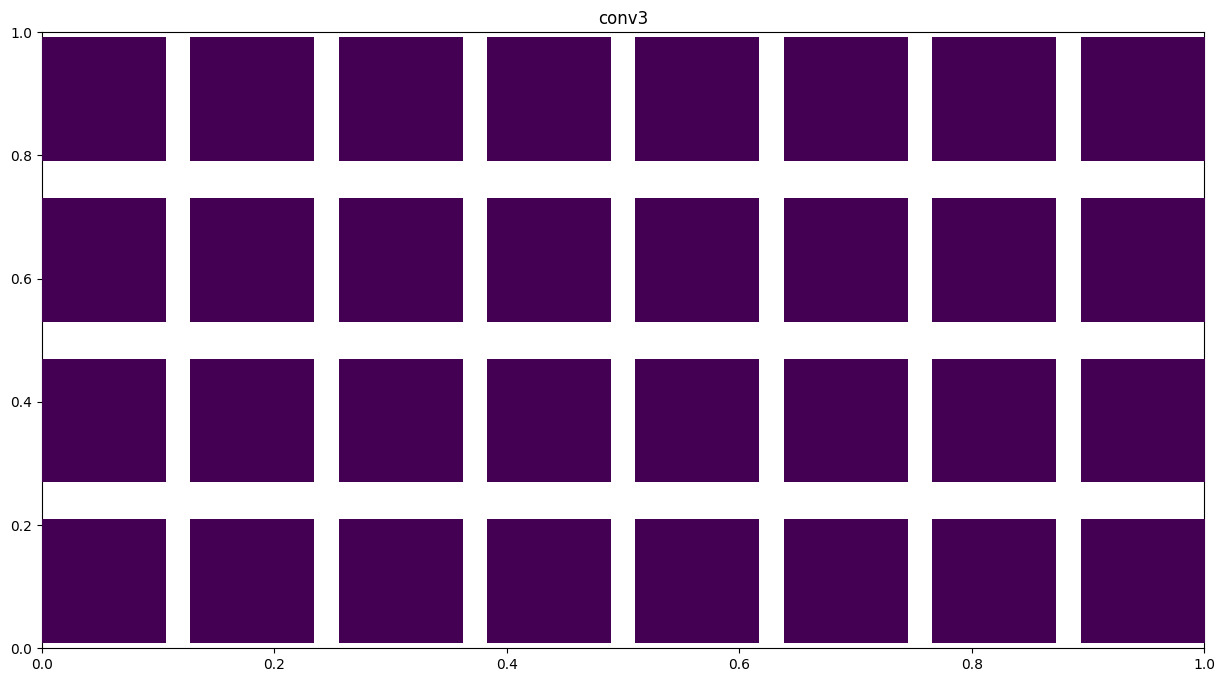

In [40]:
data_iter = iter(train_loader)
example_data, _ = next(data_iter)

example_data = example_data.to(device)

layer_names = ["conv1", "pool", "conv2", "pool", "conv3"]
with torch.no_grad():
    for i, layer_name in enumerate(layer_names):
        if "conv" in layer_name.lower() in layer_name.lower():
            example_data = getattr(model, layer_name)(example_data)
        elif "pool" in layer_name.lower():
            example_data = getattr(model, layer_name)(torch.abs(example_data))
        plot_images_grid(example_data.cpu(), layer_name)